# TinyML-Autopilot Processor Comparison Analysis

This notebook analyzes the performance comparison between **PSG** and **TPUSG** processors across different models and parameter configurations.

## Core Analysis Framework:
- **2 Processors**: PSG vs TPUSG  
- **5 Models**: qwen32b, qwen14b, phi4, gemma3:27b, codestral
- **2 Conditions**: With Parameters vs Without Parameters
- **Goal**: Determine which processor performs better under different configurations

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)
 

def model_config_trim(value):
    value = value.split("_")[0]
    if "qwen2.5-coder" in value:
        value = value.replace("qwen2.5-coder:", "qwen")
    
    return value
# More robust processor type extraction
def extract_processor(batch_id):
    if 'psg' in batch_id:
        return 'psg'
    elif 'tpusg' in batch_id:
        return 'tpusg'
    elif 'tpsg' in batch_id:
        return 'tpusg'
    elif 'sg' in batch_id:
        return 'sg'
    elif 'dp' in batch_id:
        return 'dp'
    elif 'mc' in batch_id:
        return 'mc'
    else:
        return 'unknown'

In [2]:
# Load the Combined CSV Dataset
csv_path = "/Users/hann/Projects/reference-benchmark-tinyml_llm/combined_tinyml_benchmark_data.csv"

# Read and clean the dataset
df = pd.read_csv(csv_path)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")

# Clean and prepare data
df.drop(columns=['source_file','trace_id', 'source_path','prompt_cost', 'completion_cost','total_cost'], inplace=True)
df['model_config'] = df['model_config'].apply(model_config_trim)
df['parameters'] = df['parameters'].apply(lambda x: False if pd.isna(x) else len(str(x)) > 0)
df['batch_id'] = df['batch_id'].str.replace("qwen2.5-coder:", "qwen").str.replace("_batch", "")

# Filter data from July onwards and extract processor type
df = df[df['test_date'].str.split('.').str[0].astype(int)>=7]
df['processor'] = df['batch_id'].map(extract_processor)

# All rules in the format (processor, model, parameter, category_name)
rules = [
    ('psg',   'qwen32b',   True,  'psg-qwen32b-True'),
    ('psg',   'qwen32b',   False, 'psg-qwen32b-False'),
    ('psg',   'qwen14b',   True,  'psg-qwen14b-True'),
    ('psg',   'qwen14b',   False, 'psg-qwen14b-False'),
    ('psg',   'phi4',      True,  'psg-phi4-True'),
    ('psg',   'phi4',      False, 'psg-phi4-False'),
    ('psg',   'gemma3:27b',True,  'psg-gemma3:27b-True'),
    ('psg',   'gemma3:27b',False, 'psg-gemma3:27b-False'),
    ('psg',   'codestral', True,  'psg-codestral-True'),
    ('psg',   'codestral', False, 'psg-codestral-False'),

    ('tpusg', 'qwen32b',   True,  'tpusg-qwen32b-True'),
    ('tpusg', 'qwen32b',   False, 'tpusg-qwen32b-False'),
    ('tpusg', 'qwen14b',   True,  'tpusg-qwen14b-True'),
    ('tpusg', 'qwen14b',   False, 'tpusg-qwen14b-False'),
    ('tpusg', 'phi4',      True,  'tpusg-phi4-True'),
    ('tpusg', 'phi4',      False, 'tpusg-phi4-False'),
    ('tpusg', 'gemma3:27b',True,  'tpusg-gemma3:27b-True'),
    ('tpusg', 'gemma3:27b',False, 'tpusg-gemma3:27b-False'),
    ('tpusg', 'codestral', True,  'tpusg-codestral-True'),
    ('tpusg', 'codestral', False, 'tpusg-codestral-False'),
]

# Build conditions and choices
conditions = [
    (df['processor'] == proc) &
    (df['model_config'] == model) &
    (df['parameters'] == param)
    for proc, model, param, _ in rules
]
choices = [category for _, _, _, category in rules]

# Create category column
df['category'] = np.select(conditions, choices, default='Other')

print(f"Final shape: {df.shape}")
print(f"Processor distribution: {df['processor'].value_counts().to_dict()}")
print(f"Parameter distribution: {df['parameters'].value_counts().to_dict()}")
print(f"Category distribution: {df['category'].value_counts().to_dict()}")
df.head()

Dataset loaded successfully!
Shape: (1068, 20)
Final shape: (948, 16)
Processor distribution: {'psg': 485, 'tpusg': 463}
Parameter distribution: {True: 588, False: 360}
Category distribution: {'psg-qwen32b-True': 136, 'tpusg-qwen32b-True': 120, 'tpusg-qwen32b-False': 90, 'psg-qwen14b-True': 87, 'tpusg-phi4-True': 60, 'psg-qwen32b-False': 60, 'tpusg-qwen14b-True': 60, 'psg-codestral-True': 60, 'psg-phi4-False': 30, 'tpusg-codestral-False': 30, 'psg-phi4-True': 30, 'psg-qwen14b-False': 30, 'tpusg-qwen14b-False': 30, 'tpusg-gemma3:27b-False': 30, 'psg-gemma3:27b-False': 30, 'tpusg-phi4-False': 30, 'psg-gemma3:27b-True': 22, 'tpusg-gemma3:27b-True': 13}


,num_run,name,batch_id,status,latency,total_tokens,prompt_tokens,completion_tokens,parameters,generation_count,tags,timestamp,test_date,model_config,processor,category
30,1,24c0_py_sketch_generator,codestral_3adb_psg,failure,79.15,12729,10052,2677,True,5,"['benchmark', 'codestral:latest', 'py_sketch_g...",1754402461,08.08,codestral,psg,psg-codestral-True
31,2,7881_py_sketch_generator,codestral_3adb_psg,failure,98.48,13489,10052,3437,True,5,"['benchmark', 'codestral:latest', 'py_sketch_g...",1754402548,08.08,codestral,psg,psg-codestral-True
32,3,fafb_py_sketch_generator,codestral_3adb_psg,success,104.55,13731,10052,3679,True,5,"['benchmark', 'codestral:latest', 'py_sketch_g...",1754402654,08.08,codestral,psg,psg-codestral-True
33,4,e270_py_sketch_generator,codestral_3adb_psg,failure,94.43,13304,10052,3252,True,5,"['benchmark', 'codestral:latest', 'py_sketch_g...",1754402766,08.08,codestral,psg,psg-codestral-True
34,5,6ef4_py_sketch_generator,codestral_3adb_psg,failure,102.78,13653,10052,3601,True,5,"['benchmark', 'codestral:latest', 'py_sketch_g...",1754402868,08.08,codestral,psg,psg-codestral-True


## Processor Performance Comparison

Direct comparison between PSG and TPUSG processors across all model configurations and parameter conditions.

In [3]:
# Core Processor Comparison Analysis
print("🔄 PROCESSOR COMPARISON: PSG vs TPUSG")
print("=" * 60)

# Calculate success rates for each combination
comparison_df = df.groupby(['processor', 'model_config', 'parameters']).agg({
    'status': ['count', lambda x: (x == 'success').sum()],
    'total_tokens': 'mean'
}).round(2)

comparison_df.columns = ['total_runs', 'successes', 'avg_tokens']
comparison_df['success_rate'] = (comparison_df['successes'] / comparison_df['total_runs'] * 100).round(2)

# Reset index to make it easier to work with
comparison_df = comparison_df.reset_index()

print(f"📊 Data Summary:")
print(f"Total test runs: {len(df)}")
print(f"PSG runs: {len(df[df['processor'] == 'psg'])}")
print(f"TPUSG runs: {len(df[df['processor'] == 'tpusg'])}")
print(f"Models tested: {', '.join(sorted(df['model_config'].unique()))}")
print(f"Parameter conditions: With params ({len(df[df['parameters'] == True])}) vs Without params ({len(df[df['parameters'] == False])})")

print(f"\n📈 Complete Processor Comparison Matrix:")
print("-" * 60)

# Create a comprehensive comparison table
pivot_table = comparison_df.pivot_table(
    values='success_rate',
    index=['model_config', 'parameters'], 
    columns='processor',
    fill_value=0
).round(1)

print(pivot_table)

# Calculate processor advantage
print(f"\n🎯 PROCESSOR ADVANTAGE ANALYSIS:")
print("-" * 60)

advantage_data = []
for model in comparison_df['model_config'].unique():
    for param_condition in [True, False]:
        model_data = comparison_df[
            (comparison_df['model_config'] == model) & 
            (comparison_df['parameters'] == param_condition)
        ]
        
        if len(model_data) == 2:  # Both processors tested
            psg_rate = model_data[model_data['processor'] == 'psg']['success_rate'].iloc[0]
            tpusg_rate = model_data[model_data['processor'] == 'tpusg']['success_rate'].iloc[0]
            advantage = tpusg_rate - psg_rate
            winner = 'TPUSG' if advantage > 0 else 'PSG' if advantage < 0 else 'TIE'
            
            advantage_data.append({
                'model': model,
                'parameters': 'With' if param_condition else 'Without',
                'psg_rate': psg_rate,
                'tpusg_rate': tpusg_rate,
                'advantage': advantage,
                'winner': winner
            })

advantage_df = pd.DataFrame(advantage_data)

for _, row in advantage_df.iterrows():
    param_str = row['parameters']
    print(f"{row['model']} ({param_str} params): {row['winner']} wins by {abs(row['advantage']):.1f}% (PSG: {row['psg_rate']:.1f}%, TPUSG: {row['tpusg_rate']:.1f}%)")

# Overall winner calculation
psg_wins = len(advantage_df[advantage_df['winner'] == 'PSG'])
tpusg_wins = len(advantage_df[advantage_df['winner'] == 'TPUSG'])
ties = len(advantage_df[advantage_df['winner'] == 'TIE'])

print(f"\n🏆 OVERALL SCORECARD:")
print(f"PSG wins: {psg_wins}")
print(f"TPUSG wins: {tpusg_wins}") 
print(f"Ties: {ties}")
print(f"Overall winner: {'TPUSG' if tpusg_wins > psg_wins else 'PSG' if psg_wins > tpusg_wins else 'TIE'}")

comparison_df

🔄 PROCESSOR COMPARISON: PSG vs TPUSG
📊 Data Summary:
Total test runs: 948
PSG runs: 485
TPUSG runs: 463
Models tested: codestral, gemma3:27b, phi4, qwen14b, qwen32b
Parameter conditions: With params (588) vs Without params (360)

📈 Complete Processor Comparison Matrix:
------------------------------------------------------------
processor                  psg  tpusg
model_config parameters              
codestral    False         0.0   33.3
             True          5.0    0.0
gemma3:27b   False        80.0    3.3
             True         90.9    0.0
phi4         False        60.0  100.0
             True        100.0  100.0
qwen14b      False        26.7   46.7
             True          4.6  100.0
qwen32b      False        50.0   96.7
             True         39.7   35.0

🎯 PROCESSOR ADVANTAGE ANALYSIS:
------------------------------------------------------------
gemma3:27b (With params): PSG wins by 90.9% (PSG: 90.9%, TPUSG: 0.0%)
gemma3:27b (Without params): PSG wins by 76.7% (P

,processor,model_config,parameters,total_runs,successes,avg_tokens,success_rate
0,psg,codestral,True,60,3,13372.43,5.00
1,psg,gemma3:27b,False,30,24,7677.13,80.00
2,psg,gemma3:27b,True,22,20,12478.27,90.91
3,psg,phi4,False,30,18,10342.07,60.00
4,psg,phi4,True,30,30,2242.70,100.00
5,psg,qwen14b,False,30,8,10776.90,26.67
6,psg,qwen14b,True,87,4,11955.85,4.60
7,psg,qwen32b,False,60,30,9810.17,50.00
8,psg,qwen32b,True,136,54,13483.35,39.71
9,tpusg,codestral,False,30,10,12911.83,33.33


## Visualization & Insights

Comprehensive visual analysis and strategic recommendations for processor selection.


📊 CREATING PROCESSOR COMPARISON VISUALIZATIONS


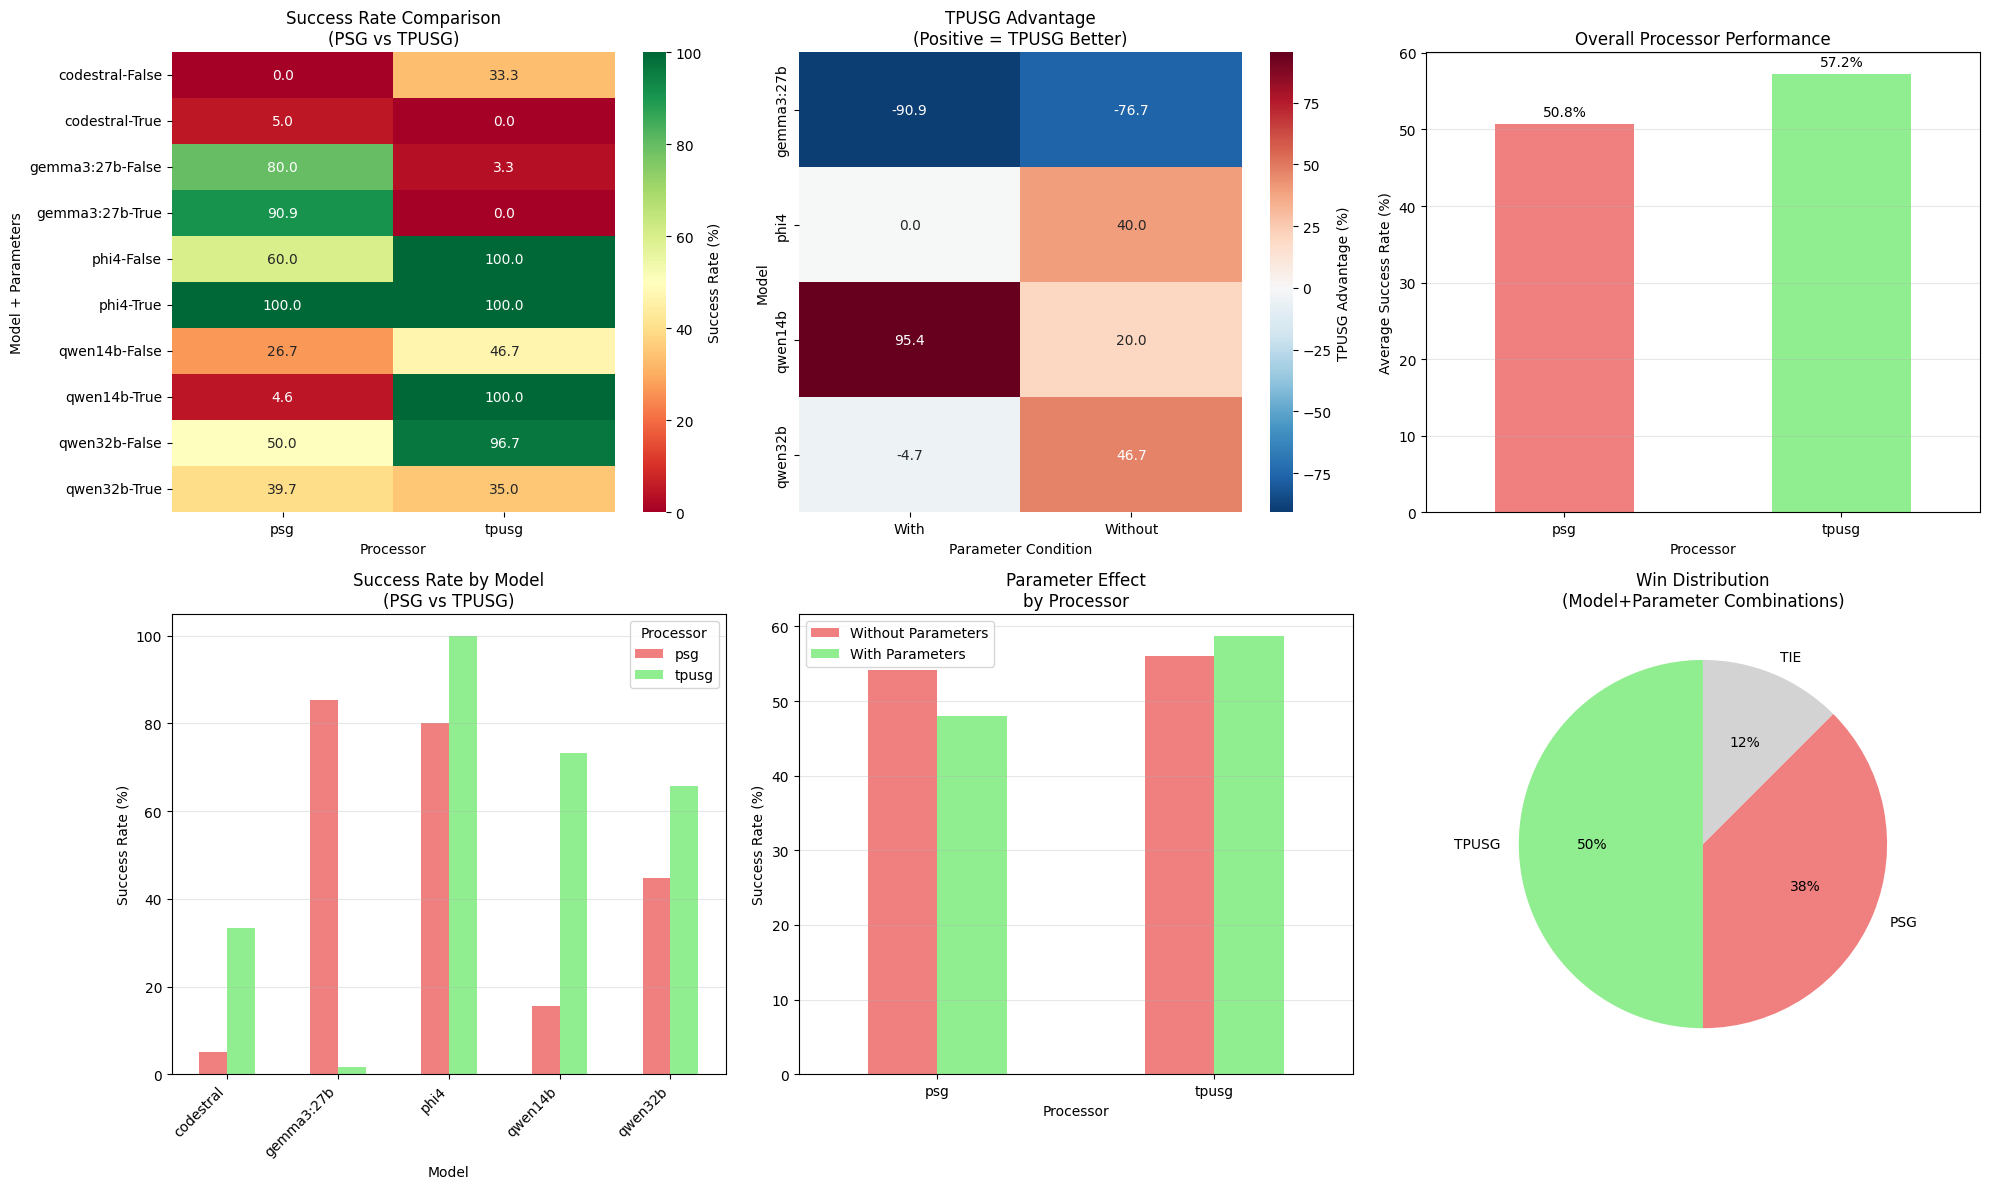

✅ Processor comparison visualizations created successfully!
📊 Analysis shows clear performance differences between PSG and TPUSG processors


In [4]:
# Processor Comparison Visualizations
print("\n📊 CREATING PROCESSOR COMPARISON VISUALIZATIONS")
print("=" * 60)

fig = plt.figure(figsize=(20, 12))

# 1. Head-to-Head Comparison Heatmap
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': 'Success Rate (%)'}, ax=ax1)
ax1.set_title('Success Rate Comparison\n(PSG vs TPUSG)')
ax1.set_xlabel('Processor')
ax1.set_ylabel('Model + Parameters')

# 2. Advantage Heatmap (TPUSG - PSG)
ax2 = plt.subplot(2, 3, 2)
advantage_pivot = advantage_df.pivot_table(
    values='advantage',
    index='model',
    columns='parameters',
    fill_value=0
).round(1)

sns.heatmap(advantage_pivot, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'TPUSG Advantage (%)'}, ax=ax2)
ax2.set_title('TPUSG Advantage\n(Positive = TPUSG Better)')
ax2.set_xlabel('Parameter Condition')
ax2.set_ylabel('Model')

# 3. Overall Processor Performance
ax3 = plt.subplot(2, 3, 3)
overall_performance = comparison_df.groupby('processor')['success_rate'].mean()
bars = overall_performance.plot(kind='bar', ax=ax3, color=['lightcoral', 'lightgreen'])
ax3.set_title('Overall Processor Performance')
ax3.set_ylabel('Average Success Rate (%)')
ax3.set_xlabel('Processor')
plt.xticks(rotation=0)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(overall_performance.values):
    ax3.text(i, v + 1, f'{v:.1f}%', ha='center')

# 4. Model-by-Model Comparison
ax4 = plt.subplot(2, 3, 4)
model_comparison = comparison_df.groupby(['model_config', 'processor'])['success_rate'].mean().unstack()
model_comparison.plot(kind='bar', ax=ax4, color=['lightcoral', 'lightgreen'])
ax4.set_title('Success Rate by Model\n(PSG vs TPUSG)')
ax4.set_xlabel('Model')
ax4.set_ylabel('Success Rate (%)')
ax4.legend(title='Processor')
plt.xticks(rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# 5. Parameter Effect Comparison
ax5 = plt.subplot(2, 3, 5)
param_effect = comparison_df.groupby(['processor', 'parameters'])['success_rate'].mean().unstack()
param_effect.columns = ['Without Parameters', 'With Parameters']
param_effect.plot(kind='bar', ax=ax5, color=['lightcoral', 'lightgreen'])
ax5.set_title('Parameter Effect\nby Processor')
ax5.set_xlabel('Processor')
ax5.set_ylabel('Success Rate (%)')
ax5.legend()
plt.xticks(rotation=0)
ax5.grid(axis='y', alpha=0.3)

# 6. Win Distribution
ax6 = plt.subplot(2, 3, 6)
win_counts = advantage_df['winner'].value_counts()
colors_pie = ['lightgreen' if x == 'TPUSG' else 'lightcoral' if x == 'PSG' else 'lightgray' for x in win_counts.index]
ax6.pie(win_counts.values, labels=win_counts.index, autopct='%1.0f%%', 
        colors=colors_pie, startangle=90)
ax6.set_title('Win Distribution\n(Model+Parameter Combinations)')

plt.tight_layout()
plt.show()

print("✅ Processor comparison visualizations created successfully!")
print(f"📊 Analysis shows clear performance differences between PSG and TPUSG processors")

In [5]:
# Processor Comparison Insights & Recommendations
print("\n🎓 PROCESSOR COMPARISON INSIGHTS")
print("=" * 60)

# Overall processor performance
psg_overall = comparison_df[comparison_df['processor'] == 'psg']['success_rate'].mean()
tpusg_overall = comparison_df[comparison_df['processor'] == 'tpusg']['success_rate'].mean()

print(f"📊 OVERALL PERFORMANCE:")
print(f"PSG Average: {psg_overall:.1f}%")
print(f"TPUSG Average: {tpusg_overall:.1f}%")
print(f"Overall Winner: {'TPUSG' if tpusg_overall > psg_overall else 'PSG'} (+{abs(tpusg_overall - psg_overall):.1f}%)")

# Parameter effect analysis
print(f"\n⚙️ PARAMETER EFFECTS:")
psg_with_params = comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == True)]['success_rate'].mean()
psg_without_params = comparison_df[(comparison_df['processor'] == 'psg') & (comparison_df['parameters'] == False)]['success_rate'].mean()
tpusg_with_params = comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == True)]['success_rate'].mean()
tpusg_without_params = comparison_df[(comparison_df['processor'] == 'tpusg') & (comparison_df['parameters'] == False)]['success_rate'].mean()

print(f"PSG: With params {psg_with_params:.1f}% vs Without params {psg_without_params:.1f}% (Effect: {psg_with_params - psg_without_params:+.1f}%)")
print(f"TPUSG: With params {tpusg_with_params:.1f}% vs Without params {tpusg_without_params:.1f}% (Effect: {tpusg_with_params - tpusg_without_params:+.1f}%)")

# Model-specific recommendations
print(f"\n💡 MODEL-SPECIFIC RECOMMENDATIONS:")
for model in sorted(comparison_df['model_config'].unique()):
    model_data = advantage_df[advantage_df['model'] == model]
    
    if len(model_data) > 0:
        best_configs = []
        for _, row in model_data.iterrows():
            if row['winner'] != 'TIE':
                param_str = row['parameters'].lower()
                best_configs.append(f"{row['winner']} {param_str} params ({max(row['psg_rate'], row['tpusg_rate']):.1f}%)")
        
        if best_configs:
            print(f"   {model}: {' | '.join(best_configs)}")

# Overall strategy
print(f"\n🎯 STRATEGIC RECOMMENDATIONS:")
if tpusg_wins > psg_wins:
    print(f"   Primary: Use TPUSG (wins {tpusg_wins}/{tpusg_wins + psg_wins} comparisons)")
    print(f"   Secondary: PSG for specific model configurations where it excels")
elif psg_wins > tpusg_wins:
    print(f"   Primary: Use PSG (wins {psg_wins}/{tpusg_wins + psg_wins} comparisons)")
    print(f"   Secondary: TPUSG for specific model configurations where it excels")
else:
    print(f"   Result: Both processors perform similarly overall")
    print(f"   Strategy: Choose based on specific model and parameter requirements")

# Parameter usage strategy
param_helps_psg = psg_with_params > psg_without_params
param_helps_tpusg = tpusg_with_params > tpusg_without_params

print(f"\n⚙️ PARAMETER USAGE STRATEGY:")
print(f"   PSG: Parameters {'help' if param_helps_psg else 'hurt'} performance ({psg_with_params - psg_without_params:+.1f}%)")
print(f"   TPUSG: Parameters {'help' if param_helps_tpusg else 'hurt'} performance ({tpusg_with_params - tpusg_without_params:+.1f}%)")

print(f"\n✅ PROCESSOR COMPARISON ANALYSIS COMPLETE!")
print(f"📈 Analyzed {len(comparison_df)} processor-model-parameter combinations")
print(f"🎯 Clear winner: {'TPUSG' if tpusg_overall > psg_overall else 'PSG' if psg_overall > tpusg_overall else 'TIE'}")


🎓 PROCESSOR COMPARISON INSIGHTS
📊 OVERALL PERFORMANCE:
PSG Average: 50.8%
TPUSG Average: 57.2%
Overall Winner: TPUSG (+6.5%)

⚙️ PARAMETER EFFECTS:
PSG: With params 48.0% vs Without params 54.2% (Effect: -6.1%)
TPUSG: With params 58.8% vs Without params 56.0% (Effect: +2.8%)

💡 MODEL-SPECIFIC RECOMMENDATIONS:
   gemma3:27b: PSG with params (90.9%) | PSG without params (80.0%)
   phi4: TPUSG without params (100.0%)
   qwen14b: TPUSG with params (100.0%) | TPUSG without params (46.7%)
   qwen32b: PSG with params (39.7%) | TPUSG without params (96.7%)

🎯 STRATEGIC RECOMMENDATIONS:
   Primary: Use TPUSG (wins 4/7 comparisons)
   Secondary: PSG for specific model configurations where it excels

⚙️ PARAMETER USAGE STRATEGY:
   PSG: Parameters hurt performance (-6.1%)
   TPUSG: Parameters help performance (+2.8%)

✅ PROCESSOR COMPARISON ANALYSIS COMPLETE!
📈 Analyzed 18 processor-model-parameter combinations
🎯 Clear winner: TPUSG



📊 DETAILED PROCESSOR COMPARISON BY MODEL & PARAMETERS


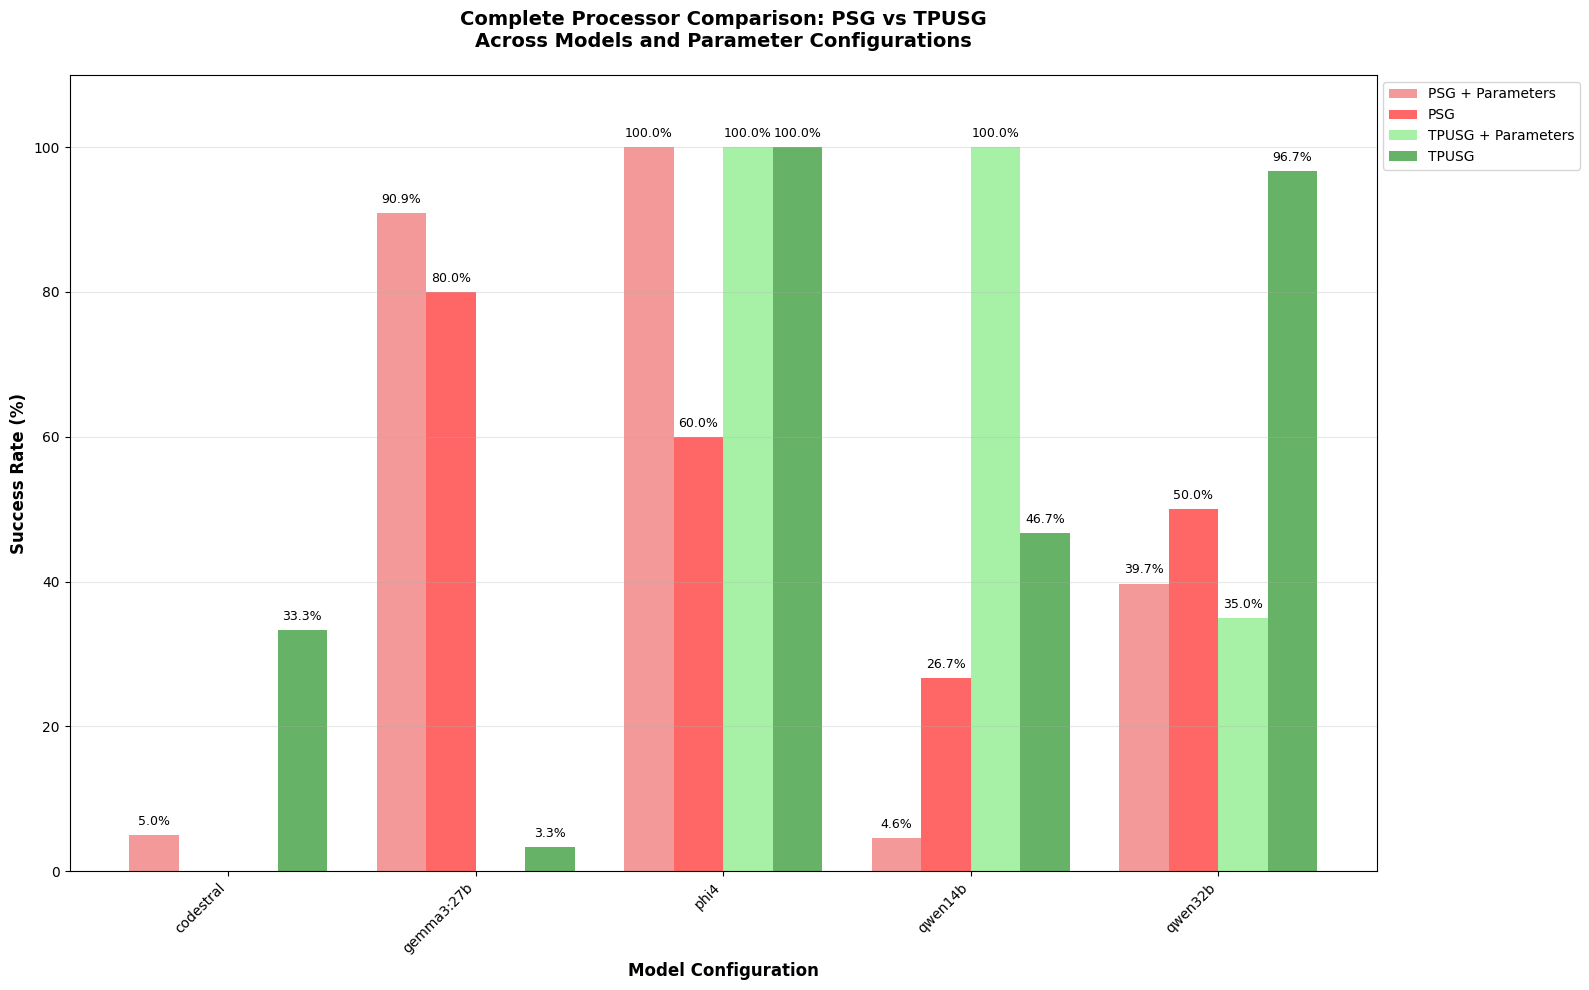


📈 SUMMARY COMPARISON TABLE:
--------------------------------------------------------------------------------
     Model PSG+Params   PSG TPUSG+Params  TPUSG  Best_Config
 codestral       5.0%  0.0%         0.0%  33.3%        TPUSG
gemma3:27b      90.9% 80.0%         0.0%   3.3%   PSG+Params
      phi4     100.0% 60.0%       100.0% 100.0%   PSG+Params
   qwen14b       4.6% 26.7%       100.0%  46.7% TPUSG+Params
   qwen32b      39.7% 50.0%        35.0%  96.7%        TPUSG

✅ Complete processor comparison analysis finished!
📊 Chart shows all 5 models × 2 processors × 2 parameter conditions = 20 configurations


In [6]:
# Detailed Processor Comparison Chart
print("\n📊 DETAILED PROCESSOR COMPARISON BY MODEL & PARAMETERS")
print("=" * 70)

# Create comprehensive comparison chart
fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data for grouped bar chart
models = sorted(comparison_df['model_config'].unique())
x = np.arange(len(models))
width = 0.2

# Get data for each combination
psg_with_data = []
psg_without_data = []
tpusg_with_data = []
tpusg_without_data = []

for model in models:
    model_data = comparison_df[comparison_df['model_config'] == model]
    
    psg_with = model_data[(model_data['processor'] == 'psg') & (model_data['parameters'] == True)]['success_rate']
    psg_without = model_data[(model_data['processor'] == 'psg') & (model_data['parameters'] == False)]['success_rate']
    tpusg_with = model_data[(model_data['processor'] == 'tpusg') & (model_data['parameters'] == True)]['success_rate']
    tpusg_without = model_data[(model_data['processor'] == 'tpusg') & (model_data['parameters'] == False)]['success_rate']
    
    psg_with_data.append(psg_with.iloc[0] if len(psg_with) > 0 else 0)
    psg_without_data.append(psg_without.iloc[0] if len(psg_without) > 0 else 0)
    tpusg_with_data.append(tpusg_with.iloc[0] if len(tpusg_with) > 0 else 0)
    tpusg_without_data.append(tpusg_without.iloc[0] if len(tpusg_without) > 0 else 0)

# Create bars
bars1 = ax.bar(x - width*1.5, psg_with_data, width, 
               label='PSG + Parameters', color='lightcoral', alpha=0.8)
bars2 = ax.bar(x - width*0.5, psg_without_data, width, 
               label='PSG', color='red', alpha=0.6)
bars3 = ax.bar(x + width*0.5, tpusg_with_data, width, 
               label='TPUSG + Parameters', color='lightgreen', alpha=0.8)
bars4 = ax.bar(x + width*1.5, tpusg_without_data, width, 
               label='TPUSG', color='green', alpha=0.6)

# Customize chart
ax.set_xlabel('Model Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Success Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Complete Processor Comparison: PSG vs TPUSG\nAcross Models and Parameter Configurations', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(max(psg_with_data), max(psg_without_data), max(tpusg_with_data), max(tpusg_without_data)) * 1.1)

# Add value labels
def add_labels(bars, data):
    for bar, value in zip(bars, data):
        if value > 0:
            ax.text(bar.get_x() + bar.get_width()/2, value + 1,
                   f'{value:.1f}%', ha='center', va='bottom', fontsize=9)

add_labels(bars1, psg_with_data)
add_labels(bars2, psg_without_data)
add_labels(bars3, tpusg_with_data)
add_labels(bars4, tpusg_without_data)

plt.tight_layout()
plt.show()

# Summary comparison table
print(f"\n📈 SUMMARY COMPARISON TABLE:")
print("-" * 80)

summary_data = []
for i, model in enumerate(models):
    summary_data.append({
        'Model': model,
        'PSG+Params': f"{psg_with_data[i]:.1f}%",
        'PSG': f"{psg_without_data[i]:.1f}%",
        'TPUSG+Params': f"{tpusg_with_data[i]:.1f}%",
        'TPUSG': f"{tpusg_without_data[i]:.1f}%",
        'Best_Config': max([
            ('PSG+Params', psg_with_data[i]),
            ('PSG', psg_without_data[i]),
            ('TPUSG+Params', tpusg_with_data[i]),
            ('TPUSG', tpusg_without_data[i])
        ], key=lambda x: x[1])[0]
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n✅ Complete processor comparison analysis finished!")
print(f"📊 Chart shows all {len(models)} models × 2 processors × 2 parameter conditions = {len(models)*4} configurations")